In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import subprocess
%matplotlib inline

# 冷却実験解析

In [2]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie

In [3]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

## APD延長効果の確認

### BCL 400ms

#### 20181106-1/C001H001S0010 (冷却なし)

In [57]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0010/'
start = 300
end = 500
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [58]:
raw1 = RawCam(path=data_path, cam_type='sa4',
              image_width=128, image_height=128, frame_start=start, frame_end=end)
raw1.setIntROI(400)
# raw.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

In [6]:
raw1.showFrame(0)
plt.plot(70, 70, 'o', color='blue')

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/Detected_point.png', dpi=600)
plt.close()

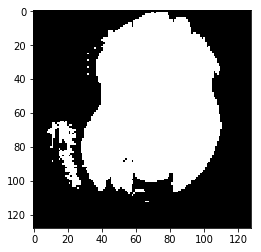

In [7]:
raw1.showROI()

In [59]:
vmem1 = VmemMap(raw1)
# vmem1.setDiffRange(diff_min=20)
# vmem1.morphROI(closing=4)
# vmem1.morphROI(erosion=4)
vmem1.smooth(size=2)

for i in range(vmem1.data.shape[1]):
    for j in range(vmem1.data.shape[2]):
#         vmem1.data[:, i, j] = FFT(vmem1.data[:, i, j], vmem1.data.shape[0], 0.002, fc_low=1, fc_high=20)
        im_range = (np.max(vmem1.data[:, i, j]) - np.min(vmem1.data[:, i, j])) + (np.max(vmem1.data[:, i, j]) == np.min(vmem1.data[:, i, j])) * 1
        vmem1.data[:, i, j] = 2.0 * (vmem1.data[:, i, j] - np.min(vmem1.data[:, i, j])) / im_range - 1.0

vmem1.data = vmem1.data * vmem1.roi

In [64]:
v = vmem1.data[50:175, 70, 70]
plt.plot((v - np.min(v))/(np.max(v)-np.min(v)))

plt.xlim([0, 125])
plt.ylim([0, 1])

plt.xticks([0, 25, 50, 75, 100, 125], [0, 50, 100, 150, 200, 250], size=14)
plt.yticks(size=14)

plt.xlabel('Time (ms)', size=14)
plt.ylabel('Normalized Membrane potential (a.u.)', size=14)

plt.tight_layout()
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/membrane_cooling_experiment.png', dpi=600)
plt.close()

In [79]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem1.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

#### 20181106-1/C001H001S0015 (冷却あり)

In [11]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0015/'
start = 4000
end = -1
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [18]:
raw2 = RawCam(path=data_path, cam_type='sa4',
              image_width=128, image_height=128, frame_start=start, frame_end=end)
raw2.setIntROI(140)
raw2.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

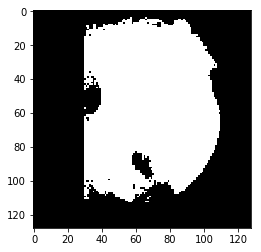

In [19]:
raw2.showROI()

In [29]:
vmem2 = VmemMap(raw2)
vmem2.setDiffRange(diff_min=50)
vmem2.morphROI(closing=3)
vmem2.morphROI(erosion=3)

vmem2.smooth(size=9)

for i in range(vmem2.data.shape[1]):
    for j in range(vmem2.data.shape[2]):
        vmem2.data[:, i, j] = FFT(vmem2.data[:, i, j], vmem2.data.shape[0], 0.002, fc_low=1, fc_high=50)
        im_range = (np.max(vmem2.data[:, i, j]) - np.min(vmem2.data[:, i, j])) + (np.max(vmem2.data[:, i, j]) == np.min(vmem2.data[:, i, j])) * 1
        vmem2.data[:, i, j] = 2.0 * (vmem2.data[:, i, j] - np.min(vmem2.data[:, i, j])) / im_range - 1.0

vmem2.data = vmem2.data * vmem2.roi

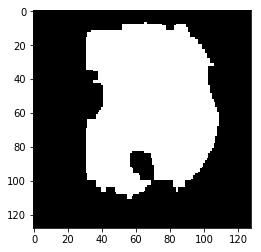

In [30]:
vmem2.showROI()

(0, 1000)

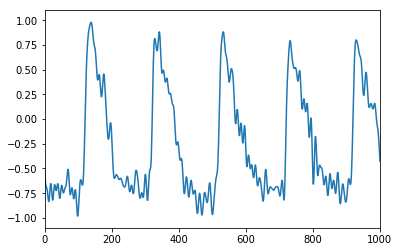

In [31]:
plt.plot(vmem2.data[:, 60, 100])
plt.xlim([0, 1000])

In [32]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem2.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

#### 20181106-1/C001H001S0016 (冷却あり)

In [40]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0016/'
start = 4000
end = -1
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [49]:
raw3 = RawCam(path=data_path, cam_type='sa4',
              image_width=128, image_height=128, frame_start=start, frame_end=end)
raw3.setIntROI(150)
raw3.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

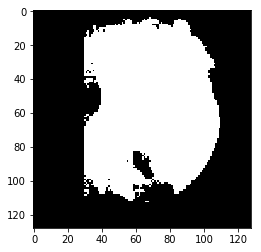

In [50]:
raw3.showROI()

In [60]:
vmem3 = VmemMap(raw3)
vmem3.setDiffRange(diff_min=20)
# vmem3.morphROI(closing=3)
# vmem3.morphROI(erosion=3)

vmem3.smooth(size=9)

for i in range(vmem3.data.shape[1]):
    for j in range(vmem3.data.shape[2]):
        vmem3.data[:, i, j] = FFT(vmem3.data[:, i, j], vmem3.data.shape[0], 0.002, fc_low=1, fc_high=50)
        im_range = (np.max(vmem3.data[:, i, j]) - np.min(vmem3.data[:, i, j])) + (np.max(vmem3.data[:, i, j]) == np.min(vmem3.data[:, i, j])) * 1
        vmem3.data[:, i, j] = 2.0 * (vmem3.data[:, i, j] - np.min(vmem3.data[:, i, j])) / im_range - 1.0

vmem3.data = vmem3.data * vmem3.roi

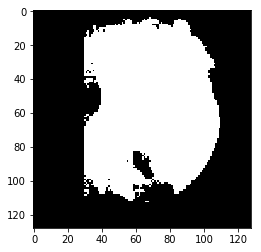

In [58]:
vmem3.showROI()

(0, 1000)

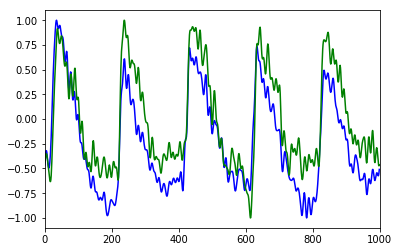

In [61]:
plt.plot(vmem3.data[:, 60, 70], color='b')
plt.plot(vmem3.data[:, 60, 100], color='g')
plt.xlim([0, 1000])

In [62]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem3.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

#### 20181106-1/C001H001S0017 (冷却あり)

In [10]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0017/'
start = 4000
end = -1
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [11]:
raw4 = RawCam(path=data_path, cam_type='sa4',
              image_width=128, image_height=128, frame_start=start, frame_end=end)
raw4.setIntROI(120)
raw4.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

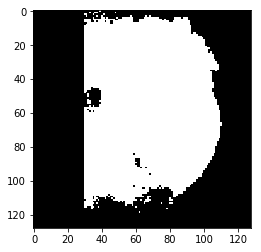

In [12]:
raw4.showROI()

In [13]:
vmem4 = VmemMap(raw4)
vmem4.setDiffRange(diff_min=20)
# vmem4.morphROI(closing=4)
# vmem4.morphROI(erosion=6)

vmem4.smooth(size=9)

for i in range(vmem4.data.shape[1]):
    for j in range(vmem4.data.shape[2]):
        vmem4.data[:, i, j] = FFT(vmem4.data[:, i, j], vmem4.data.shape[0], 0.002, fc_low=1, fc_high=20)
        im_range = (np.max(vmem4.data[:, i, j]) - np.min(vmem4.data[:, i, j])) + (np.max(vmem4.data[:, i, j]) == np.min(vmem4.data[:, i, j])) * 1
        vmem4.data[:, i, j] = 2.0 * (vmem4.data[:, i, j] - np.min(vmem4.data[:, i, j])) / im_range - 1.0

vmem4.data = vmem4.data * vmem4.roi

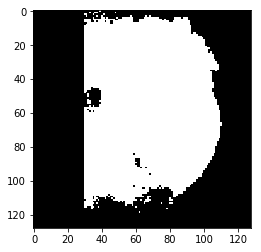

In [14]:
vmem4.showROI()

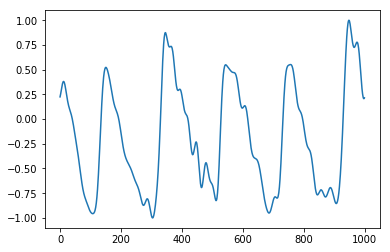

In [76]:
plt.plot(vmem4.data[:, 70, 70])

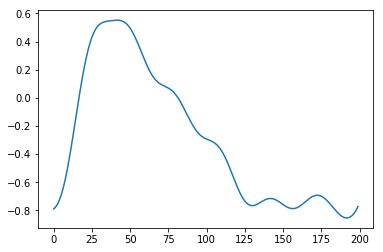

In [15]:
vmem_w_cooling = vmem4.data[715:915, 70, 70]
plt.plot(vmem_w_cooling)

In [83]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem4.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [24]:
plt.subplot(2,1,1)
plt.plot((vmem_wo_cooling-np.min(vmem_wo_cooling))/(np.max(vmem_wo_cooling)-np.min(vmem_wo_cooling)), color='g', label='w/o cooling')
plt.title("w/o cooling", size=20)
plt.xticks([])
plt.yticks(size=16)
plt.xlim([0, 200])
plt.ylim([0, 1.02])


plt.subplot(2,1,2)
plt.plot((vmem_w_cooling-np.min(vmem_w_cooling))/(np.max(vmem_w_cooling)-np.min(vmem_w_cooling)), color='b', label='w/ cooling')
plt.title("w/ cooling", size=20)
plt.xticks([0, 50, 100, 150, 200], [0, 100, 200, 300, 400], size=16)
plt.yticks(size=16)

plt.xlim([0, 200])
plt.ylim([0, 1.02])

# plt.xlabel("Time (ms)", size=14)
# plt.ylabel('Normalized membrane potential (a.u.)', size=14)

plt.tight_layout()

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/APD_BCL400_lf1_hf20.png', dpi=600)
plt.close()

In [107]:
a = (vmem_wo_cooling-np.min(vmem_wo_cooling))/(np.max(vmem_wo_cooling)-np.min(vmem_wo_cooling))

flg = 0
start = 0
end = 0


for i in range(a.shape[0]):
    if flg == 0 and a[i] >= 0.1:
        flg = 1
        start = i
    if flg == 1 and a[i] <= 0.1:
        flg = 0
        end = i
        pass

In [111]:
(end-start)*2

208

In [27]:
b = (vmem_w_cooling-np.min(vmem_w_cooling))/(np.max(vmem_w_cooling)-np.min(vmem_w_cooling))

flg = 0
start = 0
end = 0


for i in range(b.shape[0]):
    if flg == 0 and b[i] >= 0.1:
        flg = 1
        start = i
    if flg == 1 and b[i] <= 0.1:
        flg = 0
        end = i
        break

In [30]:
(end-start)*2

238

## 旋回に対する冷却

### 20181106-1/C001H001S0018 (40~50秒で停止)

In [19]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0018/'
start = 20200
end = 21200
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [20]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)
raw.setIntROI(150)
raw.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

In [21]:
raw.showFrame(0)
plt.plot(70, 70, 'o', color='blue')
plt.plot(100, 60, 'o', color='green')

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/Detected_point.png', dpi=600)
plt.close()

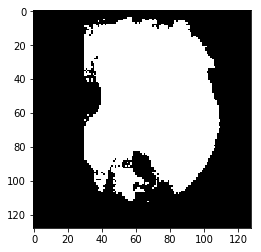

In [22]:
raw.showROI()

In [23]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [24]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=20)
# vmem.morphROI(closing=4)
# vmem.morphROI(erosion=4)

vmem.smooth(size=3)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=4, fc_high=50)
#         im_range = (np.max(vmem.data[:, i, j]) - np.min(vmem.data[:, i, j])) + (np.max(vmem.data[:, i, j]) == np.min(vmem.data[:, i, j])) * 1
#         vmem.data[:, i, j] = 2.0 * (vmem.data[:, i, j] - np.min(vmem.data[:, i, j])) / im_range - 1.0

vmem.data = vmem.data * vmem.roi

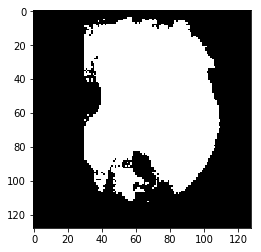

In [9]:
vmem.showROI()

In [10]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))    

for i in range(vmem.data.shape[0]):
    num_save = "{0:06d}".format(i)
    num = "{0:05d}".format((start+i)*2)
    plt.imshow(vmem.data[i, :, :], cmap=vmem.cmap, vmin=vmem.vmin, vmax=vmem.vmax)
    plt.xticks([])
    plt.yticks([])
    plt.text(7, 15, "%s (ms)" % num, color='white', fontsize=20)
    plt.savefig(os.path.join(save_parent, 'vmem/%s.png')%num_save)
    plt.close()
    
cmd = 'ffmpeg -r 30 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [48]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [24]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))

pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

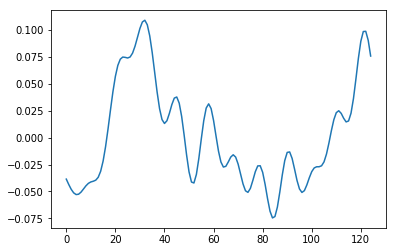

In [43]:
plt.plot(vmem.data[290:415, 60, 100])

In [37]:
plt.subplot(2,1,1)
plt.plot(vmem.data[400:900, 60, 100], color='g', label='w/o cooling')
plt.title("w/o cooling", size=20)
plt.xticks([])
plt.yticks([-0.10, 0.00, 0.10], size=14)
plt.xlim([0, 500])
plt.ylim([-0.1, 0.1])


plt.subplot(2,1,2)
plt.plot(vmem.data[400:900, 70, 70], color='b', label='w/ cooling')
plt.title("w/ cooling", size=20)
plt.xticks([0, 100, 200, 300, 400, 500], [20.6, 20.8, 21.0, 21.2, 21.4, 21.6], size=14)
plt.yticks([-0.10, 0.00, 0.10], size=14)

plt.xlim([0, 500])
plt.ylim([-0.1, 0.1])

# plt.xlabel("Time (ms)", size=14)
# plt.ylabel('Normalized membrane potential (a.u.)', size=14)

plt.tight_layout()

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/vmem.png', dpi=600)
plt.close()

### 20181106-1/C001H001S0020 (停止)

In [4]:
data_path = '/mnt/recordings/ExperimentData/20181106-1/C001H001S0020/'
start = 9300
end = 9800
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [5]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=128, image_height=128, frame_start=start, frame_end=end)
raw.setIntROI(90)
raw.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

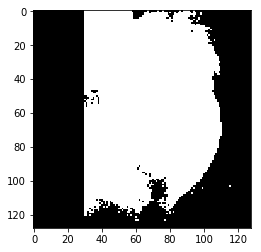

In [6]:
raw.showROI()

In [7]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 60 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [8]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=20)
# vmem.morphROI(closing=4)
# vmem.morphROI(erosion=4)

vmem.smooth(size=9)

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=3, fc_high=50)
#         im_range = (np.max(vmem.data[:, i, j]) - np.min(vmem.data[:, i, j])) + (np.max(vmem.data[:, i, j]) == np.min(vmem.data[:, i, j])) * 1
#         vmem.data[:, i, j] = 2.0 * (vmem.data[:, i, j] - np.min(vmem.data[:, i, j])) / im_range - 1.0

vmem.data = vmem.data * vmem.roi

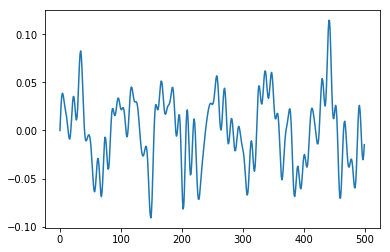

In [51]:
plt.plot(vmem.data[:, 60, 100])
# plt.xlim([9000, 10000])

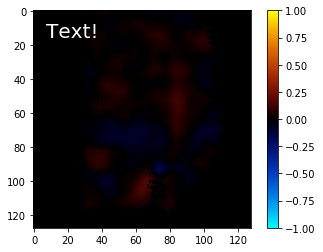

In [9]:
plt.imshow(vmem.data[0, :, :], cmap=vmem.cmap, vmin=vmem.vmin, vmax=vmem.vmax)
plt.text(7, 15, "Text!", color='white', fontsize=20)
plt.colorbar()

In [10]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))    

for i in range(vmem.data.shape[0]):
    num_save = "{0:06d}".format(i)
    num = "{0:05d}".format((9300+i)*2)
    plt.imshow(vmem.data[i, :, :], cmap=vmem.cmap, vmin=vmem.vmin, vmax=vmem.vmax)
    plt.xticks([])
    plt.yticks([])
    plt.text(7, 15, "%s (ms)" % num, color='white', fontsize=20)
    plt.savefig(os.path.join(save_parent, 'vmem/%s.png')%num_save)
    plt.close()
    
cmd = 'ffmpeg -r 30 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [46]:
pmap = PhaseMap(vmem, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))

pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

##### 日本光電システムの波形確認

In [52]:
import pandas as pd

sample = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/sample.csv',
                     header=9, engine='python', encoding='us-ascii')
S0018 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0018.csv',
                    header=9, engine='python', encoding='us-ascii')
S0020 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0020.csv',
                    header=9, engine='python', encoding='us-ascii')
S0021 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0021.csv',
                    header=9, engine='python', encoding='us-ascii')

In [53]:
a = sample[['mV.3']].values[:-1]
a = a.astype(np.float64)

In [73]:
plt.plot(a[1950:3950])

plt.xticks([0, 500, 1000, 1500, 2000], size=18)
plt.yticks([-0.30, -0.20, -0.10, 0.00, 0.10], size=18)

plt.xlim([0, 2000])

plt.xlabel('Time (ms)', size=18)
plt.ylabel('Electrode signal (mV)', size=18)

plt.tight_layout()

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/ECG_sample.png', dpi=600, transparent=True)
plt.close()

In [264]:
plt.plot(a[9500:10500], linewidth=3)
plt.xticks([0, 500, 1000], [-36, -35.5, -35], size=20)
plt.yticks(size=20)
plt.ylim([-0.25, 0.25])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_-36_-35.png', dpi=600, transparent=True)
plt.close()

In [269]:
plt.plot(a[45000:46000], linewidth=3)
plt.xticks([0, 500, 1000], [-0.5, 0, 0.5], size=20)
plt.yticks([])
plt.ylim([-0.25, 0.25])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_0.png', dpi=600, transparent=True)
plt.close()

In [271]:
plt.plot(a[66000:67000], linewidth=3)
plt.xticks([0, 500, 1000], [20.5, 21, 21.5], size=20)
plt.yticks([])
plt.ylim([-0.25, 0.25])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_21.png', dpi=600, transparent=True)
plt.close()

In [275]:
plt.plot(a[87000:88000], linewidth=3)
plt.xticks([0, 500, 1000], [41.5, 42, 42.5], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_42.png', dpi=600, transparent=True)
plt.close()

# ペーシング動画

In [12]:
data_path = '/mnt/Jalife/ExperimentData/20180426-2/C001H001S0001/'
start = 0
end = 1000
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [13]:
raw = RawCam(path=data_path, cam_type='sa4',
             image_width=512, image_height=512, frame_start=start, frame_end=end)
raw.setIntROI(150)
# raw.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

In [31]:
vmem = VmemMap(raw)
vmem.setDiffRange(diff_min=20)
# vmem.morphROI(closing=4)
# vmem.morphROI(erosion=4)

vmem.smooth(size=9)

# for i in range(vmem.data.shape[1]):
#     for j in range(vmem.data.shape[2]):
#         vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=4, fc_high=50)
#         im_range = (np.max(vmem.data[:, i, j]) - np.min(vmem.data[:, i, j])) + (np.max(vmem.data[:, i, j]) == np.min(vmem.data[:, i, j])) * 1
#         vmem.data[:, i, j] = 2.0 * (vmem.data[:, i, j] - np.min(vmem.data[:, i, j])) / im_range - 1.0

# vmem.data = vmem.data * vmem.roi

In [8]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [51]:
# plt.plot(FFT(vmem.data[:, 256, 256], vmem.data.shape[0], 0.001, fc_low=3, fc_high=100))
v = vmem.data[:, 256, 256]
plt.plot((v - np.min(v))/(np.max(v)-np.min(v)))

plt.xlim([0, 250])
plt.ylim([0, 1])

plt.xticks(size=14)
plt.yticks(size=14)

plt.xlabel('Time (ms)', size=14)
plt.ylabel('Normalized Membrane potential (a.u.)', size=14)

plt.tight_layout()
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/membrane.png', dpi=600)
plt.close()